In [4]:
# library to convert .mat to np.array()
%pip install mat73

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Channel download
import mat73

data = mat73.loadmat('ChannelQriga_Freq_3kmh_Scena0_test_MIR_GIT_RAW_NR_3GPP_3D_UMa_NLOS_3p5GHz.mat')
# data

In [7]:
import numpy as np

H_initial = data['Hfrq'][0]['Chan']
H_dl = H_initial.transpose(1, 0, 2, 3)[:12, :, 0:600:12, :15] / np.abs(H_initial.max())
H_dl.shape


(12, 4, 50, 15)

/Users/pavelkr/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/pavelkr/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


15

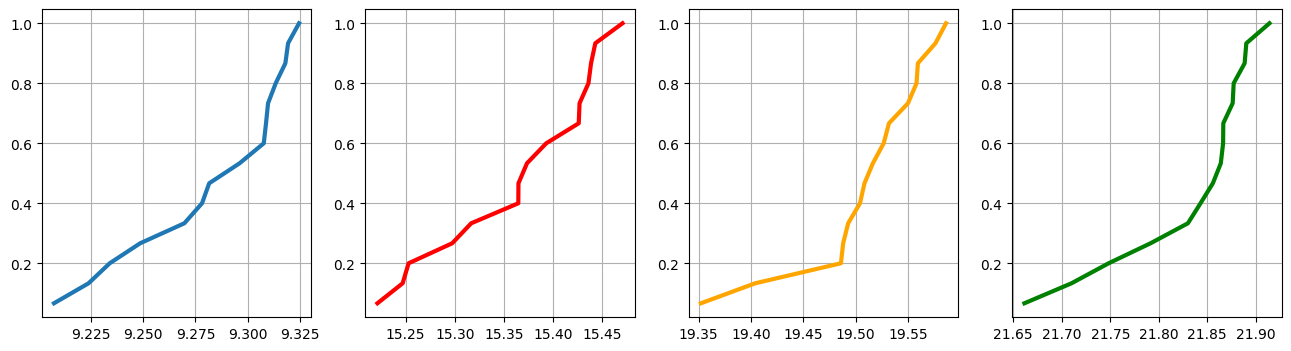

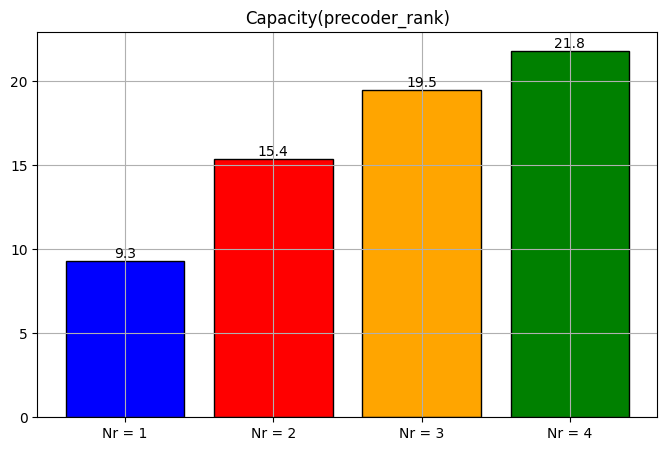

In [8]:
# Capacity of initial Channel
from extr_func import get_Capacity, cdf
import matplotlib.pyplot as plt

SNR = 30
channel_shape = list(H_dl.shape) + [1]

fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # 1 строка, 4 столбца

Nr = 1  # precoder rank
Capacity1 = get_Capacity(H_dl, H_dl, Nr, SNR, channel_shape)
sort_capacity1, Capacity_ideal_distr1 = cdf(Capacity1)
axs[0].plot(sort_capacity1, Capacity_ideal_distr1, lw=3)
axs[0].grid()

Nr = 2  # precoder rank
Capacity2 = get_Capacity(H_dl, H_dl, Nr, SNR, channel_shape)
sort_capacity2, Capacity_ideal_distr2 = cdf(Capacity2)
axs[1].plot(sort_capacity2, Capacity_ideal_distr2, 'r', lw=3)
axs[1].grid()

Nr = 3  # precoder rank
Capacity3 = get_Capacity(H_dl, H_dl, Nr, SNR, channel_shape)
sort_capacity3, Capacity_ideal_distr3 = cdf(Capacity3)
axs[2].plot(sort_capacity3, Capacity_ideal_distr3, 'orange', lw=3)
axs[2].grid()

Nr = 4  # precoder rank
Capacity4 = get_Capacity(H_dl, H_dl, Nr, SNR, channel_shape)
sort_capacity4, Capacity_ideal_distr4 = cdf(Capacity4)
axs[3].plot(sort_capacity4, Capacity_ideal_distr4, 'g', lw=3)
axs[3].grid()


Capacity1_mean = float(np.mean(Capacity1))
Capacity2_mean = float(np.mean(Capacity2))
Capacity3_mean = float(np.mean(Capacity3))
Capacity4_mean = float(np.mean(Capacity4))

categories = ['Nr = 1', 'Nr = 2', 'Nr = 3', 'Nr = 4']
values = [Capacity1_mean, Capacity2_mean, Capacity3_mean, Capacity4_mean]

plt.figure(figsize=(8, 5))
named_colors = ['b', 'r', 'orange', 'g']
bars = plt.bar(categories, values, color=named_colors, edgecolor='black')
plt.grid()

# Добавляем значения над столбцами
plt.title('Capacity(precoder_rank)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',  # Форматирование до 1 знака после запятой
             ha='center', va='bottom')
    
len(Capacity4)

In [9]:
# tensorly CPD_ALS
from tensorly.decomposition import parafac
from tensorly.cp_tensor import cp_to_tensor

RankCP = 12
weights, factors = parafac(H_dl, rank=RankCP, n_iter_max=100, tol=1e-6, verbose=True)

reconstruction error=0.7066779744893124
iteration 1, reconstruction error: 0.1810989835603406, decrease = 0.5255789909289718, unnormalized = 12.948439823814937
iteration 2, reconstruction error: 0.1362174032234885, decrease = 0.044881580336852106, unnormalized = 9.739440906403496
iteration 3, reconstruction error: 0.11837403366347782, decrease = 0.017843369560010675, unnormalized = 8.463653530573705
iteration 4, reconstruction error: 0.10793946013376755, decrease = 0.010434573529710264, unnormalized = 7.7175894457269365
iteration 5, reconstruction error: 0.10144820258000907, decrease = 0.006491257553758484, unnormalized = 7.253469459168753
iteration 6, reconstruction error: 0.09690117803284193, decrease = 0.004547024547167142, unnormalized = 6.928360656408489
iteration 7, reconstruction error: 0.09347037586718258, decrease = 0.003430802165659344, unnormalized = 6.683060906425892
iteration 8, reconstruction error: 0.09085601409920631, decrease = 0.0026143617679762754, unnormalized = 6.4

/Users/pavelkr/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/pavelkr/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Nr = 1:  0.23 %
Nr = 2:  0.35 %
Nr = 3:  0.69 %
Nr = 4:  0.84 %


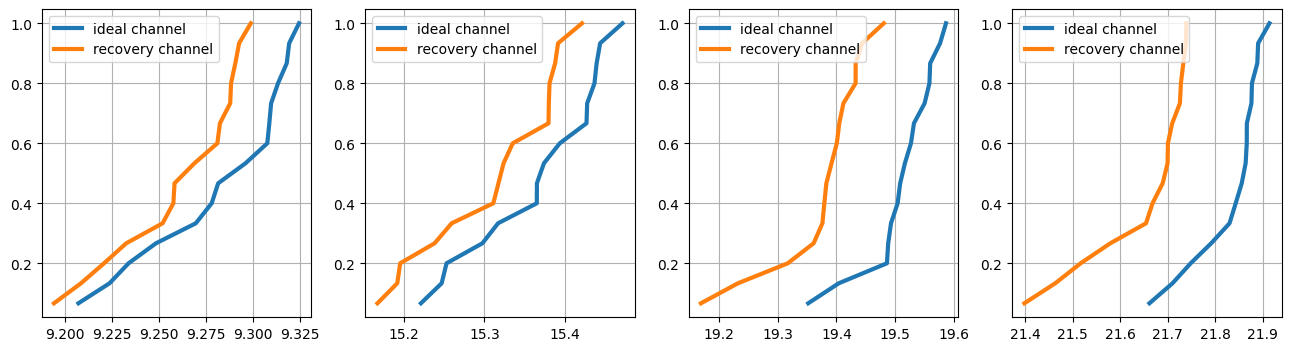

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # 1 строка, 4 столбца

H_dl_reconstr = cp_to_tensor((weights, factors))
ideal_capacity = [sort_capacity1, sort_capacity2, sort_capacity3, sort_capacity4]
ideal_cdf_capacity = [Capacity_ideal_distr1, Capacity_ideal_distr2, Capacity_ideal_distr3, Capacity_ideal_distr4]

errors = [0] * 4

for i in range(4):
    Nr = i + 1  # precoder rank
    Capacity_rec_1 = get_Capacity(H_dl, H_dl_reconstr, Nr, SNR, channel_shape)
    sort_capacity_rec, Capacity_rec_distr = cdf(Capacity_rec_1)
    axs[i].plot(ideal_capacity[i], ideal_cdf_capacity[i], lw=3)
    axs[i].plot(sort_capacity_rec, Capacity_rec_distr, lw=3)
    axs[i].grid()
    axs[i].legend(['ideal channel', 'recovery channel'])

    error = (np.mean(ideal_capacity[i]) - np.mean(sort_capacity_rec)) / np.mean(ideal_capacity[i]) * 100
    errors[i] = round(float(error), 2)
    # print(f'Error = {error} %')

for i in range(4):
    print(f'Nr = {i + 1}: ', errors[i], '%')


Iteration 0, relative error: 4.2575e-01
Iteration 1, relative error: 2.1552e-01
Iteration 2, relative error: 1.7083e-01
Iteration 3, relative error: 1.4944e-01
Iteration 4, relative error: 1.3613e-01
Iteration 5, relative error: 1.2678e-01
Iteration 6, relative error: 1.2007e-01
Iteration 7, relative error: 1.1532e-01
Iteration 8, relative error: 1.1186e-01
Iteration 9, relative error: 1.0925e-01
Iteration 10, relative error: 1.0722e-01
Iteration 11, relative error: 1.0560e-01
Iteration 12, relative error: 1.0426e-01
Iteration 13, relative error: 1.0312e-01
Iteration 14, relative error: 1.0214e-01
Iteration 15, relative error: 1.0127e-01
Iteration 16, relative error: 1.0049e-01
Iteration 17, relative error: 9.9780e-02
Iteration 18, relative error: 9.9130e-02
Iteration 19, relative error: 9.8530e-02
Iteration 20, relative error: 9.7973e-02
Iteration 21, relative error: 9.7453e-02
Iteration 22, relative error: 9.6967e-02
Iteration 23, relative error: 9.6512e-02
Iteration 24, relative err

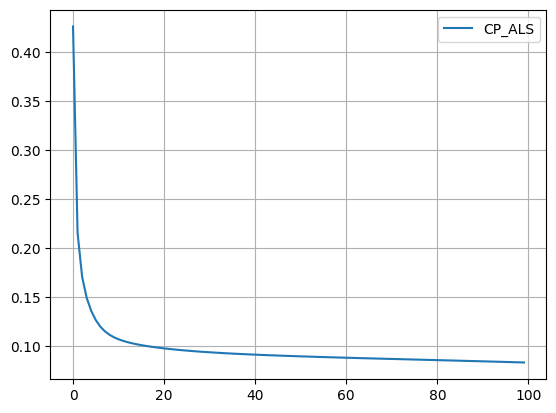

In [11]:
# my CPD_ALS and CPD_ALS_QR and CPD_Gradient compare (also test on images)
from CP_ALS import cp_als_complex, reconstruct_tensor
import matplotlib.pyplot as plt

RankCP = 12
data_cp_als = cp_als_complex(H_dl, RankCP, 100)
H_dl_reconstr = reconstruct_tensor(data_cp_als['lambdas'], data_cp_als['factors'])

plt.plot(data_cp_als['errors'])
plt.grid()
plt.legend(['CP_ALS'])

Nr = 1, CP_ALS Error:  0.06 %
Nr = 2, CP_ALS Error:  0.28 %
Nr = 3, CP_ALS Error:  0.42 %
Nr = 4, CP_ALS Error:  1.15 %


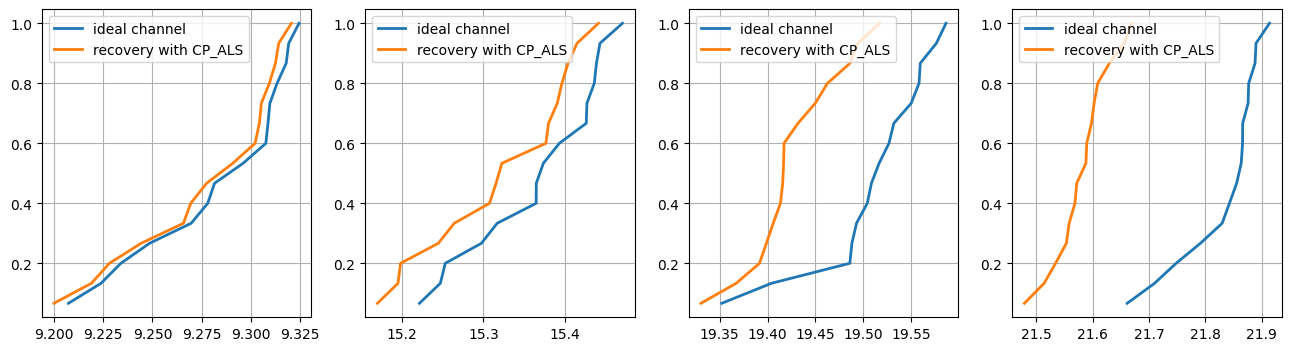

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # 1 строка, 4 столбца

ideal_capacity = [sort_capacity1, sort_capacity2, sort_capacity3, sort_capacity4]
ideal_cdf_capacity = [Capacity_ideal_distr1, Capacity_ideal_distr2, Capacity_ideal_distr3, Capacity_ideal_distr4]

errors = [0] * 4

for i in range(4):
    Nr = i + 1  # precoder rank
    Capacity_rec_1 = get_Capacity(H_dl, H_dl_reconstr, Nr, SNR, channel_shape)
    sort_capacity_rec1, Capacity_rec_distr1 = cdf(Capacity_rec_1)

    axs[i].plot(ideal_capacity[i], ideal_cdf_capacity[i], lw=2)
    axs[i].plot(sort_capacity_rec1, Capacity_rec_distr1, lw=2)
    axs[i].grid()
    axs[i].legend(['ideal channel', 'recovery with CP_ALS', 'recovery with CP_ALS_QR'])

    error = (np.mean(ideal_capacity[i]) - np.mean(sort_capacity_rec1)) / np.mean(ideal_capacity[i]) * 100
    errors[i] = (round(float(error), 2))
    # print(f'Error = {error} %')

for i in range(4):
    print(f'Nr = {i + 1}, CP_ALS Error: ', errors[i], '%')

In [54]:
print('Initial shape: ', H_dl.shape)
print()
print('Shape after compression: ')
print(data_cp_als['factors'][0].shape)
print(data_cp_als['factors'][1].shape)
print(data_cp_als['factors'][2].shape)
print(data_cp_als['factors'][3].shape)

Initial shape:  (12, 4, 50, 15)

Shape after compression: 
(12, 12)
(4, 12)
(50, 12)
(15, 12)


In [55]:
# My method compression: Tensorization + CPD_ALS on MIMO channel
from Tensorization import reshape_with_prime_factors

print(H_dl.shape)
H_dl_reshape = reshape_with_prime_factors(H_dl)
print(H_dl_reshape.shape)
data_cp_als_tenz = cp_als_complex(H_dl_reshape, RankCP)

(12, 4, 50, 15)
(2, 2, 3, 2, 2, 2, 5, 5, 3, 5)
Iteration 0, relative error: 7.5342e-01
Iteration 1, relative error: 3.4184e-01
Iteration 2, relative error: 2.9124e-01
Iteration 3, relative error: 2.6042e-01
Iteration 4, relative error: 2.4510e-01
Iteration 5, relative error: 2.3479e-01
Iteration 6, relative error: 2.2725e-01
Iteration 7, relative error: 2.2386e-01
Iteration 8, relative error: 2.2228e-01
Iteration 9, relative error: 2.2120e-01
Iteration 10, relative error: 2.2041e-01
Iteration 11, relative error: 2.1983e-01
Iteration 12, relative error: 2.1942e-01
Iteration 13, relative error: 2.1912e-01
Iteration 14, relative error: 2.1888e-01
Iteration 15, relative error: 2.1868e-01
Iteration 16, relative error: 2.1851e-01
Iteration 17, relative error: 2.1835e-01
Iteration 18, relative error: 2.1819e-01
Iteration 19, relative error: 2.1804e-01
Iteration 20, relative error: 2.1788e-01
Iteration 21, relative error: 2.1772e-01
Iteration 22, relative error: 2.1755e-01
Iteration 23, relati

In [56]:
from Tensorization import inverse_reshape_with_prime_factors

# prime_dims = (2, 2, 3, 2, 2, 2, 5, 5, 3, 5)
target_dims = (12, 4, 50, 15)

# recon_tenz = reconstruct_from_cp(data_cp_als_tenz['factors'], prime_dims, target_dims)
# loss_tenz_init = np.linalg.norm(H_dl - recon_tenz) / np.linalg.norm(H_dl)
# loss_tenz_init

chan_est = inverse_reshape_with_prime_factors(H_dl_reshape, target_dims)
chan_est.shape

(12, 4, 50, 15)

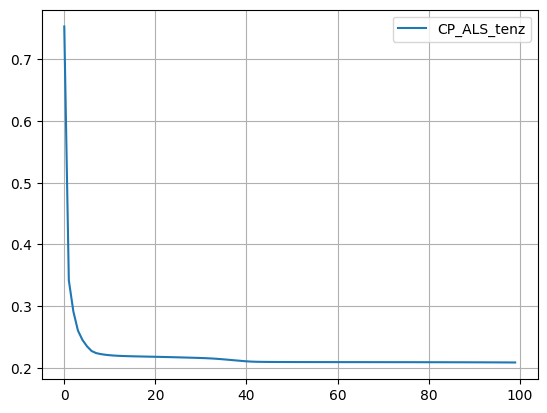

In [57]:
plt.plot(data_cp_als_tenz['errors'])
plt.grid()
plt.legend(['CP_ALS_tenz'])

In [58]:
lamdas = data_cp_als_tenz['lambdas']
factors = data_cp_als_tenz['factors']

recon_tenz = reconstruct_tensor(lamdas, factors)
recon_tenz.shape


(2, 2, 3, 2, 2, 2, 5, 5, 3, 5)

In [59]:
tens_est_tenz = inverse_reshape_with_prime_factors(recon_tenz, target_dims)
tens_est_tenz.shape

(12, 4, 50, 15)

In [60]:
rel_error = np.linalg.norm(H_dl - tens_est_tenz) / np.linalg.norm(H_dl)
rel_error

0.20865804078743638

In [64]:
Nr = 1
Capacity_id = get_Capacity(H_dl, H_dl, Nr, SNR, channel_shape)
Capacity_rec = get_Capacity(H_dl, tens_est_tenz, Nr, SNR, channel_shape)

error = (np.mean(Capacity_id[i]) - np.mean(Capacity_rec)) / np.mean(Capacity_id[i]) * 100
error

1.4397484330782135